# **import the library**

In [23]:
import os
import shutil
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import Resize
import random

# **Dataset Selection**

In [24]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"ihmaidanalhaj","key":"4ee2c52d9fe156c26e530865f91f5096"}'}

In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [26]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection
!unzip brain-tumor-detection.zip -d br35h_dataset --force


Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-tumor-detection.zip
caution: filename not matched:  --force


In [27]:

tumor_path = 'br35h_dataset/yes'
no_tumor_path = 'br35h_dataset/no'

tumor_count = len(os.listdir(tumor_path))
no_tumor_count = len(os.listdir(no_tumor_path))

print(f"Tumor images: {tumor_count}")
print(f"No tumor images: {no_tumor_count}")


Tumor images: 1500
No tumor images: 1500


the dataset here is balanced

# **making the dataset Imbalance for the project**

In [28]:
# Create new folders
os.makedirs('imbalanced_data/tumor', exist_ok=True)
os.makedirs('imbalanced_data/no_tumor', exist_ok=True)

# Create the new main directory
os.makedirs('imbalanced_data', exist_ok=True)

# Move 'no_tumor' and 'tumor' folders into 'imbalanced_data'
if os.path.exists('no_tumor'):
    shutil.move('no_tumor', 'imbalanced_data/no_tumor')

if os.path.exists('tumor'):
    shutil.move('tumor', 'imbalanced_data/tumor')

print("Folders moved into 'imbalanced_data' successfully.")

Folders moved into 'imbalanced_data' successfully.


In [29]:
# Copy 200 tumor images (minority)
tumor_images = os.listdir('br35h_dataset/yes')[:200]
for img in tumor_images:
    src = os.path.join('br35h_dataset/yes', img)
    dst = os.path.join('imbalanced_data/tumor', img)
    shutil.copyfile(src, dst)

# Copy all no_tumor images (majority)
no_tumor_images = os.listdir('br35h_dataset/no')
for img in no_tumor_images:
    src = os.path.join('br35h_dataset/no', img)
    dst = os.path.join('imbalanced_data/no_tumor', img)
    shutil.copyfile(src, dst)

print(f"Tumor (minority) images: {len(os.listdir('imbalanced_data/tumor'))}")
print(f"No Tumor (majority) images: {len(os.listdir('imbalanced_data/no_tumor'))}")

Tumor (minority) images: 200
No Tumor (majority) images: 1500


# **visualize imbalanced classes**

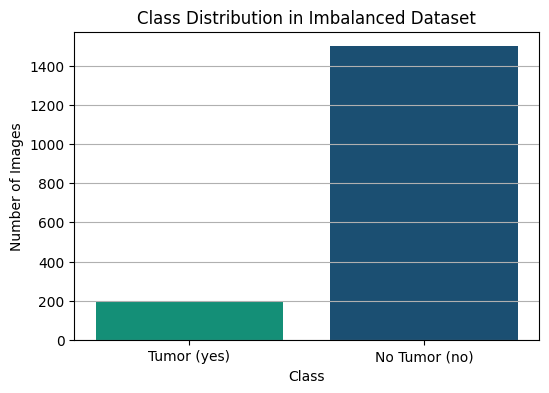

In [30]:
#Count images in each class
tumor_count = len(os.listdir('imbalanced_data/tumor'))
no_tumor_count = len(os.listdir('imbalanced_data/no_tumor'))

# Data for plotting
classes = ['Tumor (yes)', 'No Tumor (no)']
counts = [tumor_count, no_tumor_count]

# Plot
plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['#148f77', '#1b4f72'])
plt.title('Class Distribution in Imbalanced Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.grid(axis='y')
plt.show()


# **Split the dataset into train and validation**

In [31]:
# ==== 1. Setup ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "imbalanced_data"
img_size = 64
batch_size = 32
epochs = 10

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [32]:
from torch.utils.data import random_split

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# **Define the CNN classifier**

In [33]:
class TumorCNN(nn.Module):
    def __init__(self):
        super(TumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 channel (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

model = TumorCNN().to(device)


# **Train the CNN**

In [34]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_acc_list, val_acc_list = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_acc = correct / total
    train_acc_list.append(train_acc)

# **Testing and Evaluation**

In [35]:
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 10/10 - Loss: 2.3456, Train Acc: 0.9824, Val Acc: 0.9471


Evaluation Metrics:
Accuracy:  0.9471
Precision: 0.8696
Recall:    0.5714
F1-Score:  0.6897
AUC-ROC:   0.9642


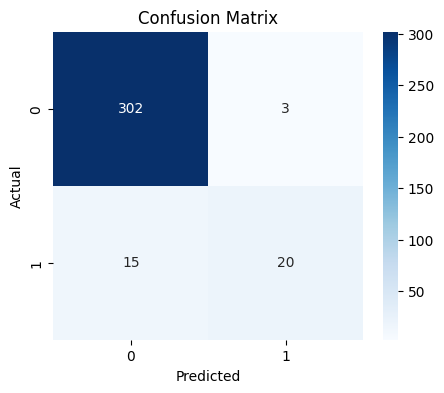

In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import seaborn as sns

# ==== Collect predictions ====
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Flatten
all_labels = [int(l[0]) for l in all_labels]
all_preds = [int(p[0]) for p in all_preds]
all_probs = [float(p[0]) for p in all_probs]

# ==== Metrics ====
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# ==== Confusion Matrix ====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
